<a href="https://colab.research.google.com/github/ekaratnida/Applied-machine-learning/blob/master/Solving_MNIST_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

digit_recognizer_path = kagglehub.competition_download('digit-recognizer')

print('Data source import complete.')


# Identifying hand-written digits(MNIST) using PyTorch

We will use the famous <b>MNIST Handwritten Digits Databases</b> as our training dataset.It consists of 28px by 28px grayscale images of handwritten disgits(0 - 9), along with labels for each image indicating which digit it represents. MNIST stands for <b>Modified National Institute of Standards and Technology.</b>

![image.png](attachment:image.png)

<font color='black'><h2 align = 'center' style = 'background:LightGray'> Quick Navigation </h2></font>
#### [1. Brief about PyTorch](#1)
#### [2. Working with images in PyToch(using MNIST Dataset)](#2)
#### [3. Splitting a dataset into training, Validation and test sets](#3)
#### [4. Creating PyTorch models with custom logic by extending the nn.Module Class](#4)
#### [5. Interpreting model outputs as probabilities using softmax, and picking predicted labels](#5)
#### [6. Picking a good evaluation metric(accuracy) and loss function(cross entropy) for Classification problems](#6)
#### [7.Setting up a training loop that also evaluates the model using Validation set](#7)
#### [8. Testing the model manually on randomly picked examples](#8)
#### [9.Saving and loading the model checkpoints to avoid retraining from scratch](#9)
#### [10. References](#10)

PyTorch is an optimized tensor library for deep learning using GPUs and CPUs.

<h1><font color='red'> If you learn anything new from this notebook, Please upvote....</font></h1>

In [1]:
## Imports
import torch
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

We will import <b>torchvision</b> which contains some utility functions for working with the image data. It also contain helper classes to automatically download and import the famous datasets like MNIST.

MNIST dataset has 60,000 images which can be used to train the model. There is also an additional test set of 10,000 images which can be created by passing <b>train = False</b> to the MNIST class.

### Loading the MNIST dataset

In [2]:
dataset = MNIST(root = 'data/', download = True)
print(len(dataset))

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.94MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 62.8kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.45MB/s]

60000


Label: 3


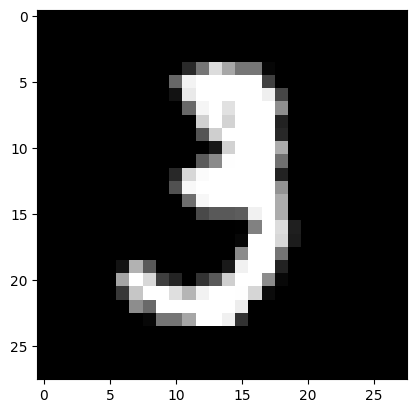

In [3]:
image, label = dataset[10]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

These images are small in size, and recognizing the digits can sometimes be hard. <b>PyTorch</b> doesn't know how to work with images. We need to convert the images into <b>tensors</b>. We can do this by specifying a <b>transform</b> while creating our dataset.

PyTorch datasets allow us to specify one or more transformation function which are applied to the images as they are loaded.

<b>torchvision.transforms</b> contains many such predefined functions and we will use <b>ToTensor</b> transform to convert images into Pytorch tensors.

### Loading the MNIST data with transformation applied while loading

In [4]:
## MNIST dataset(images and labels)
mnist_dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor())
print(mnist_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
image_tensor, label = mnist_dataset[0]
print(image_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now convert to a <b>28 X 28 tensor</b>.The first dimension is used to keep track of the color channels. Since images in the <b>MNIST dataset are grayscale</b>, there's just one channel. Other datasets have images with color, in that case the color channels would be <b>3(Red, Green, Blue).</b>

In [6]:
print(image_tensor[:,10:15,10:15])
print(torch.max(image_tensor), torch.min(image_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white and the values between different shades of grey. We can also plot the tensor as an image using lt.imshow

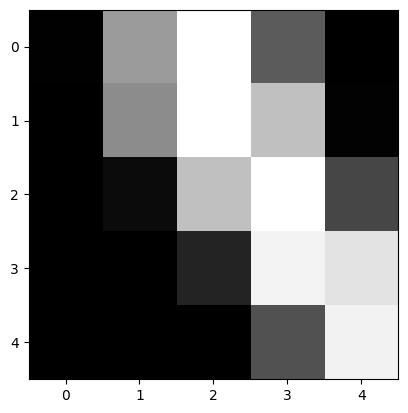

In [7]:
## Plot the image of the tensor
plt.imshow(image_tensor[0,10:15,10:15],cmap = 'gray')

## Training and Validation Datasets

In [8]:
train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

length of Train Datasets:  50000
length of Validation Datasets:  10000


While building a machine learning/Deep learning models, it is common to split the dataset into 3 parts:

1. <b>Training set</b> - The part of the data will be used to train the model,compute the loss and adjust the weights of the model using gradient descent.


2. <b>Validation set</b> - This part of the dataset will be used to evalute the traing model, adjusting the hyperparameters and pick the best version of the model.


3. <b>Test set</b> - This part of the dataset is used to final check the model predictions on the new unseen data to evaluate how well the model is performing.

In [9]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

Here we will use <b>DataLoaders</b> to help us load the data in batches. We will use a batch size of 128. We will set <b>shuffle = True</b> for the training dataloader, so that the batches generated in each epoch are different, and this randomization helps in generalizing and speed up the process.

Since Validation dataloader is used only for evaluating the model, there is no need to shuffle the images.

## Model

<b>Logistic Regression</b> model is identical to a linear regression model i.e, there are weights and bias matrices, and the output is obtained using simple matrix operations(pred = x@ w.t() + b).

We can use <b>nn.Linear</b> to create the model instead of defining and initializing the matrices manually.

Since <b>nn.Linear</b> expects the each training example to a vector, each <b>1 X 28 X 28</b> image tensor needs to be flattened out into a vector of size <b>784(28 X 28)</b>, before being passed into the model.

The output for each image is vector of size 10, with each element of the vector signifying the probability a particular target <b>label(i.e 0 to 9)</b>. The predicted label for an image is simply the one with the highest probability.

In [10]:
import torch.nn as nn

input_size = 28 * 28
num_classes = 10

## Logistic regression model
model = nn.Linear(input_size, num_classes)
print(model.weight.shape)
print(model.weight)
print(model.bias.shape)
print(model.bias)

torch.Size([10, 784])
Parameter containing:
tensor([[-0.0263, -0.0285, -0.0244,  ...,  0.0069,  0.0027, -0.0079],
        [ 0.0293,  0.0101,  0.0038,  ...,  0.0242, -0.0018,  0.0135],
        [ 0.0095,  0.0331,  0.0215,  ...,  0.0072, -0.0272, -0.0234],
        ...,
        [-0.0220, -0.0120, -0.0234,  ...,  0.0129,  0.0318,  0.0016],
        [-0.0012, -0.0109, -0.0319,  ...,  0.0033,  0.0027, -0.0189],
        [-0.0046, -0.0150,  0.0357,  ..., -0.0144, -0.0107,  0.0243]],
       requires_grad=True)
torch.Size([10])
Parameter containing:
tensor([ 0.0006,  0.0179,  0.0348, -0.0336, -0.0052,  0.0327, -0.0073,  0.0057,
         0.0309,  0.0172], requires_grad=True)


In [12]:
'''for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    break'''

'for images, labels in train_loader:\n    print(labels)\n    print(images.shape)\n    outputs = model(images)\n    break'

**Note** This leads to an error, because our input data does not have the right shape.
Our images are of the shape 1X28X28, but we need them to be vectors of size 784 i.e we need to flatten them out. We will use the <b>.reshape()</b> method of a tensor, which will allow us to efficiently view each image as a flat vector, without really changing the underlying data.

To include this additional functionality within model, we need to define a custom model, by extending the <b>nn.Module</b> class from PyTorch.

### Defining the Logistic Model

In [13]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        print(xb)
        out = self.linear(xb)
        print(out)
        return(out)

model = MnistModel()
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0107, -0.0110, -0.0069,  ..., -0.0301, -0.0281,  0.0343],
         [ 0.0328,  0.0048,  0.0357,  ..., -0.0106,  0.0214,  0.0023],
         [ 0.0196, -0.0047, -0.0173,  ..., -0.0028,  0.0006,  0.0068],
         ...,
         [ 0.0216, -0.0004,  0.0043,  ...,  0.0270, -0.0009,  0.0084],
         [-0.0180, -0.0244,  0.0117,  ...,  0.0274, -0.0075, -0.0109],
         [ 0.0021,  0.0291, -0.0089,  ..., -0.0355, -0.0059,  0.0135]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0256, -0.0250, -0.0190,  0.0127, -0.0035,  0.0271, -0.0238, -0.0066,
         -0.0074, -0.0195], requires_grad=True)]

Inside the __init__  constructor method, we instantiate the weights and biases using <b>nn.Linear</b>. Inside the <b>forward method</b>, which is invoked when we pass a batch of inputs to the model, we flatten out the input tensor, and then pass it into <b>self.linear</b>.

<b>xb.reshape(-1, 28 * 28)</b> indicates to PyTorch that we want a view of the <b>xb</b> tensor with two dimensions, where the length along the 2nd dimension is <b>28 * 28(i.e 784)</b>. One argument to <b>.reshape</b> can be set to <b>-1(in this case the first dimension)</b>, to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has <b>.weight and .bias </b>attributes(as they are now inside the <b>.linear attribute)</b>,but it does have a <b>.parameters</b> method which returns a list containg the <b>weights and bias</b>, and can be used by a <b>PyTorch optimizer</b>.

In [14]:
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs shape: ', outputs.shape)
print('Sample outputs: \n', outputs[:2].data)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[ 0.1079,  0.2195, -0.3128,  ..., -0.2764, -0.1683,  0.1478],
        [-0.2373,  0.4591, -0.3207,  ..., -0.3549, -0.1618,  0.5247],
        [ 0.1756,  0.1307, -0.3994,  ..., -0.1713, -0.0396,  0.1185],
        ...,
        [ 0.1373,  0.1470, -0.0841,  ..., -0.4795, -0.2970,  0.1066],
        [-0.1622, -0.0303, -0.0974,  ..., -0.1476, -0.2211, -0.0887],
        [-0.0356,  0.0402, -0.0697,  ..., -0.3796, -0.3143,  0.0782]],
       grad_fn=<AddmmBackward0>)
outputs shape:  torch.Size([128, 10])
Sample outputs: 
 tensor([[ 0.1079,  0.2195, -0.3128, -0.0225,  0.1495, -0.2420,  0.0637, -0.2764,
         -0.1683,  0.1478],
        [-0.2373,  0.4591, -0.3207,  0.6345, -0.0687,  0.0766,  0.0011, -0.3549,
         -0.1618,  0.5247]])


For each of the 100 input images, we get 10 outputs, one for each class. These outputs represent probabilities, but for the that the output row should lie between 0 to 1 and add upto 1.

For converting the output to probabilities such that it lies between 0 to 1 we use <b>Softmax function</b>.

## What is Softmax function?

#### The softmax function is a function that turns a vector of K real values into a vector of K real values that sum to 1. The input values can be positive, negative, zero, or greater than one, but the softmax transforms them into values between 0 and 1, so that they can be interpreted as probabilities. If one of the inputs is small or negative, the softmax turns it into a small probability, and if an input is large, then it turns it into a large probability, but it will always remain between 0 and 1.

#### The softmax function is sometimes called the softargmax function, or multi-class logistic regression. This is because the softmax is a generalization of logistic regression that can be used for multi-class classification, and its formula is very similar to the sigmoid function which is used for logistic regression. The softmax function can be used in a classifier only when the classes are mutually exclusive.

#### Many multi-layer neural networks end in a penultimate layer which outputs real-valued scores that are not conveniently scaled and which may be difficult to work with. Here the softmax is very useful because it converts the scores to a normalized probability distribution, which can be displayed to a user or used as input to other systems. For this reason it is usual to append a softmax function as the final layer of the neural network.

![image.png](attachment:image.png)

## How it is Calculated ?

![image.png](attachment:image.png)

![image.png](attachment:image.png)

In [15]:
## Apply softmax for each output row
probs = F.softmax(outputs, dim = 1)

## chaecking at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

print("\n")
## Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())
max_probs, preds = torch.max(probs, dim = 1)
print("\n")
print(preds)
print("\n")
print(max_probs)

Sample probabilities:
 tensor([[0.1132, 0.1265, 0.0743, 0.0993, 0.1180, 0.0798, 0.1083, 0.0771, 0.0859,
         0.1178],
        [0.0702, 0.1408, 0.0646, 0.1678, 0.0831, 0.0961, 0.0891, 0.0624, 0.0757,
         0.1504]])


Sum:  1.0


tensor([1, 3, 0, 9, 3, 3, 9, 9, 1, 9, 9, 9, 9, 6, 9, 4, 1, 3, 1, 1, 1, 3, 9, 3,
        9, 9, 9, 4, 9, 2, 3, 0, 3, 1, 9, 3, 1, 3, 9, 3, 3, 4, 3, 3, 9, 4, 4, 3,
        3, 3, 1, 9, 3, 1, 9, 9, 9, 4, 9, 9, 9, 2, 9, 9, 9, 3, 9, 3, 9, 3, 9, 9,
        3, 0, 4, 1, 3, 9, 3, 9, 1, 3, 9, 3, 3, 1, 3, 4, 9, 1, 3, 3, 9, 3, 3, 4,
        3, 4, 9, 4, 4, 1, 1, 9, 9, 9, 3, 9, 9, 9, 9, 5, 9, 3, 3, 9, 9, 9, 9, 3,
        3, 9, 9, 9, 3, 3, 3, 9])


tensor([0.1265, 0.1678, 0.1212, 0.1448, 0.1541, 0.1960, 0.1387, 0.1424, 0.1196,
        0.1237, 0.1643, 0.1434, 0.1269, 0.1233, 0.1553, 0.1277, 0.1397, 0.1766,
        0.1144, 0.1228, 0.1293, 0.2119, 0.1359, 0.1418, 0.1490, 0.1412, 0.1412,
        0.1254, 0.1189, 0.1238, 0.1623, 0.1261, 0.1397, 0.1377, 0.1456, 0.1410,
        0

In [16]:
labels

tensor([9, 0, 4, 1, 2, 3, 7, 4, 9, 9, 7, 4, 7, 4, 1, 9, 7, 6, 3, 2, 0, 6, 1, 9,
        5, 1, 1, 9, 9, 7, 0, 5, 6, 9, 2, 2, 7, 7, 2, 5, 0, 6, 6, 0, 7, 9, 7, 5,
        3, 0, 4, 3, 0, 4, 8, 0, 0, 1, 7, 8, 8, 7, 1, 2, 6, 0, 5, 9, 0, 6, 3, 1,
        3, 4, 8, 7, 2, 8, 1, 1, 7, 6, 2, 6, 8, 2, 6, 6, 3, 9, 9, 3, 7, 5, 9, 7,
        0, 7, 9, 7, 4, 3, 0, 4, 4, 4, 3, 1, 1, 7, 5, 0, 3, 3, 6, 9, 9, 8, 9, 2,
        2, 5, 4, 1, 3, 8, 3, 9])

## Evaluation Metric and Loss Function

Here we evaluate our model by finding the percentage of labels that were predicted correctly i.e. the <b>accuracy</b> of the predictions.

The <b>==</b> performas an element-wise comparision of two tensors with the same shape, and returns a tensor of the same shape,containing <b>0s</b> for unequal elements, and <b>1s</b> for equal elements. Passing the result to <b>torch.sum</b> returns the number of labels that were predicted correctly. Finally we divide by the total total number of images to get the accuracy.

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

print("Accuracy: ",accuracy(outputs, labels))
print("\n")
loss_fn = F.cross_entropy
print("Loss Function: ",loss_fn)
print("\n")
## Loss for the current batch
loss = loss_fn(outputs, labels)
print(loss)

Accuracy:  tensor(0.1250)


Loss Function:  <function cross_entropy at 0x7b84a818b6a0>


tensor(2.3398, grad_fn=<NllLossBackward0>)


While accuracy is a great way to evluate the model, it can't be used as a loss function for optimizing our model using gradient descent in this case for the following reasons:

- > It does not take into account the actual probabilities predicted by the model,so it can't provide sufficient feedback for increemental improvements.

Due to this reason accuracy is a great evaluation metric for classification metric ,but not a good loss function.A commonly used loss function for classification problems is the <b>Cross Entropy</b>.

## What is Cross-Entropy

<b>Cross-entropy</b> is commonly used to quantify the difference between two probabilities distribution. Usually the "True" distribution(the one that your machine learning algorithm is trying to match) is expressed in terms of a one-hot distribution.

For example, suppose for a specific training instance,the label is B(out of possible labels A,B and C).The one-hot distribution for this training instance is therefore.

![image.png](attachment:image.png)

We can interpret the above "True" distribution to mean that the training instance has 0% probability of being Class A, 100% probability of Class B and 0% probability of being Class C.

Now suppose the machine learning algorithm predicts the following probability distribution:

![image.png](attachment:image.png)

Now to check how this probability distribution is close to True distribution.Here we will use the <b>Cross-entropy loss function.</b>

![image.png](attachment:image.png)

Here <b>p(x) = output probability</b>, and <b>q(x) = Actual probability</b>.

The sum is over the three classes A,B and C.In this case the loss is<b>0.479.</b>

![image.png](attachment:image.png)

## Training the Model

Here is the pseudo-code which we will use to trainthe model

![image.png](attachment:image.png)

In [18]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return(out)

    def training_step(self, batch):
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        return(loss)

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return({'val_loss':loss, 'val_acc': acc})

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})

    def epoch_end(self, epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


model = MnistModel()

In [19]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return(model.validation_epoch_end(outputs))

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        ## Training Phas
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        ## Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [20]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3435800075531006, 'val_acc': 0.06853243708610535}

The initial accuracy is around 8% which is one might expect from a randomly initialized model.

We are ready to train the model. Let's train for 5 epochs

In [21]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9653, val_acc: 0.6093
Epoch [1], val_loss: 1.6917, val_acc: 0.7288
Epoch [2], val_loss: 1.4879, val_acc: 0.7619
Epoch [3], val_loss: 1.3346, val_acc: 0.7794
Epoch [4], val_loss: 1.2169, val_acc: 0.7936


In [22]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1246, val_acc: 0.8045
Epoch [1], val_loss: 1.0505, val_acc: 0.8136
Epoch [2], val_loss: 0.9899, val_acc: 0.8202
Epoch [3], val_loss: 0.9396, val_acc: 0.8242
Epoch [4], val_loss: 0.8969, val_acc: 0.8280


In [23]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8604, val_acc: 0.8326
Epoch [1], val_loss: 0.8288, val_acc: 0.8355
Epoch [2], val_loss: 0.8010, val_acc: 0.8384
Epoch [3], val_loss: 0.7766, val_acc: 0.8405
Epoch [4], val_loss: 0.7548, val_acc: 0.8425


In [24]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7352, val_acc: 0.8442
Epoch [1], val_loss: 0.7176, val_acc: 0.8455
Epoch [2], val_loss: 0.7016, val_acc: 0.8475
Epoch [3], val_loss: 0.6869, val_acc: 0.8488
Epoch [4], val_loss: 0.6735, val_acc: 0.8506


Text(0.5, 1.0, 'Accuracy Vs. No. of epochs')

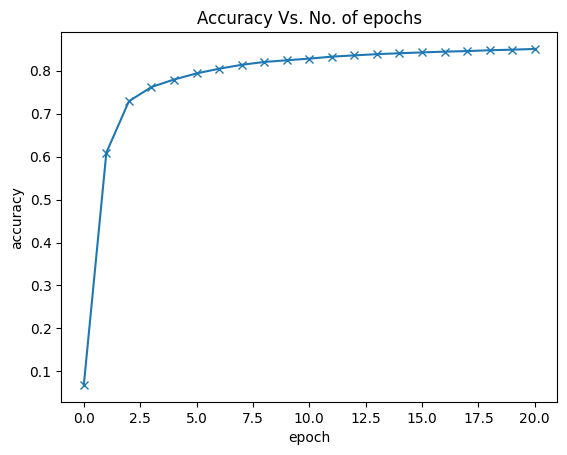

In [25]:
## Replace these values with your result
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of epochs')

## Testing with individual images

In [26]:
## Define the test dataset
test_dataset = MNIST(root = 'data/', train = False, transform = transforms.ToTensor())

shape:  torch.Size([1, 28, 28])
Label:  7


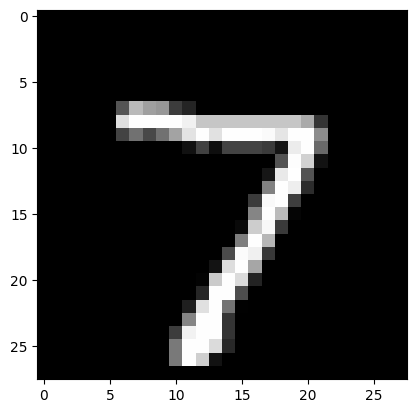

In [27]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print("shape: ", img.shape)
print('Label: ', label)

In [28]:
print(img.unsqueeze(0).shape)
print(img.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])


In [29]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return(preds[0].item())

Label: 7 , Predicted : 7


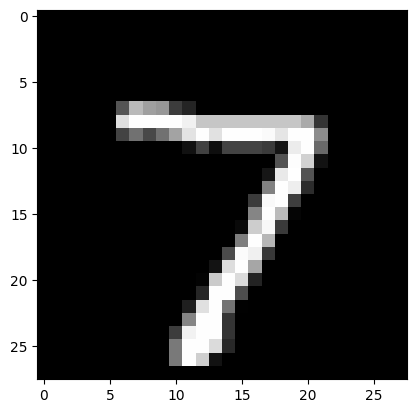

In [30]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print('Label:', label, ', Predicted :', predict_image(img, model))

Label: 9 ,Predicted: 9


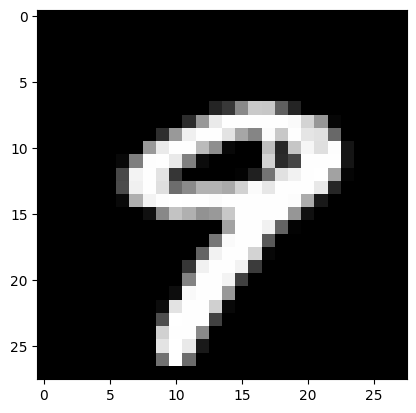

In [31]:
img, label = test_dataset[9]
plt.imshow(img[0], cmap = 'gray')
print("Label:", label, ',Predicted:', predict_image(img, model))

Label: 0 ,Predicted: 0


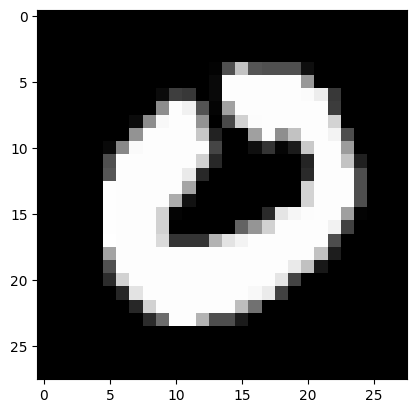

In [32]:
img, label = test_dataset[25]
plt.imshow(img[0], cmap = 'gray')
print("Label:", label, ',Predicted:', predict_image(img, model))

Label: 3 ,Predicted: 3


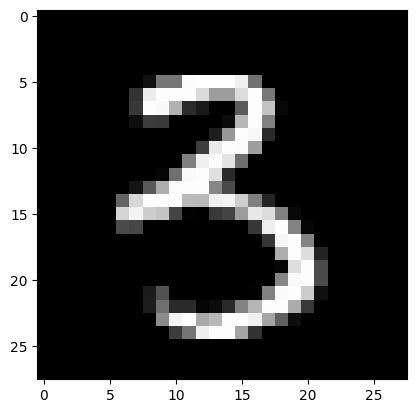

In [33]:
img, label = test_dataset[5000]
plt.imshow(img[0], cmap = 'gray')
print("Label:", label, ',Predicted:', predict_image(img, model))

In [34]:
test_loader = DataLoader(test_dataset, batch_size = 256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6442108154296875, 'val_acc': 0.859179675579071}

## Saving and loading the Model

In [35]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The <b>.state_dict</b> method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model.

In [36]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0119, -0.0277,  0.0320,  ...,  0.0211,  0.0343, -0.0055],
                      [-0.0300,  0.0112, -0.0072,  ..., -0.0070, -0.0054,  0.0214],
                      [ 0.0169, -0.0008,  0.0074,  ...,  0.0175,  0.0058,  0.0351],
                      ...,
                      [ 0.0223,  0.0177, -0.0027,  ...,  0.0252, -0.0177, -0.0073],
                      [ 0.0151, -0.0300, -0.0109,  ...,  0.0318,  0.0340, -0.0350],
                      [ 0.0280, -0.0234, -0.0053,  ...,  0.0341, -0.0067, -0.0187]])),
             ('linear.bias',
              tensor([-0.0625,  0.0635, -0.0171, -0.0011,  0.0365,  0.0434, -0.0180,  0.0223,
                      -0.1017, -0.0334]))])

In [37]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0119, -0.0277,  0.0320,  ...,  0.0211,  0.0343, -0.0055],
                      [-0.0300,  0.0112, -0.0072,  ..., -0.0070, -0.0054,  0.0214],
                      [ 0.0169, -0.0008,  0.0074,  ...,  0.0175,  0.0058,  0.0351],
                      ...,
                      [ 0.0223,  0.0177, -0.0027,  ...,  0.0252, -0.0177, -0.0073],
                      [ 0.0151, -0.0300, -0.0109,  ...,  0.0318,  0.0340, -0.0350],
                      [ 0.0280, -0.0234, -0.0053,  ...,  0.0341, -0.0067, -0.0187]])),
             ('linear.bias',
              tensor([-0.0625,  0.0635, -0.0171, -0.0011,  0.0365,  0.0434, -0.0180,  0.0223,
                      -0.1017, -0.0334]))])

In [38]:
test_loader = DataLoader(test_dataset, batch_size = 256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.6442108154296875, 'val_acc': 0.859179675579071}

## Credits

#### [1. https://jovian.ai/aakashns/03-logistic-regression](#1)
#### [2. https://deepai.org/machine-learning-glossary-and-terms/softmax-layer](#2)
#### [3. https://stackoverflow.com/questions/41990250/what-is-cross-entropy](#3)
#### [4. https://en.wikipedia.org/wiki/MNIST_database](#4)
#### [5. https://github.com/pytorch/pytorch](#5)